In [88]:
import pandas as pd 
import numpy as np 
import networkx as nx 
import matplotlib.pyplot as plt
from collections import defaultdict

In [89]:
import mplhep
import uproot

from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import KFold 
from xgboost import XGBClassifier 

import awkward as ak

In [90]:

import pandas as pd
import torch
from torch_geometric.data import Data, Batch
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
from torch_geometric.data import DataLoader

In [91]:
def uprootOpenFile(filePath, decayTree='pions'):
    with uproot.open(filePath) as file:
        df = file[decayTree].arrays(library='ak')
    
    return df

In [92]:
pho_df = uprootOpenFile("Photons_PGun.root", "photons")
negpi_df = uprootOpenFile("NegPions_PGun.root", "pions")

pho_pd_df = ak.to_dataframe(pho_df)
negpi_pd_df = ak.to_dataframe(negpi_df)

#pho_df.fields

In [93]:
print(pho_pd_df.columns)

Index(['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'B1', 'B2', 'B3',
       'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'EtotF', 'EtotB', 'region',
       'Ndiff'],
      dtype='object')


In [94]:
df = pho_pd_df

In [114]:
# Check if CUDA is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the edges as tuples of feature column names (corresponding to indices of nodes)
edges = [('F1', 'F2'), ('F2', 'F3'), ('F4', 'F5'), ('F5', 'F6'), 
         ('F7', 'F8'), ('F8', 'F9'), ('F5', 'F2'), ('F5', 'F8'),
         # Add edges connecting 'F' columns to 'B' columns if needed
         ('F1', 'B1'), ('F2', 'B2'), ('F3', 'B3'), ('F4', 'B4'),
         ('F5', 'B5'), ('F6', 'B6'), ('F7', 'B7'), ('F8', 'B8'),
         ('F9', 'B9'),
         # Back planes connected:
         ('B1', 'B2'), ('B2', 'B3'), ('B4', 'B5'), ('B5', 'B6'), 
         ('B7', 'B8'), ('B8', 'B9'), ('B5', 'B2'), ('B5', 'B8'),
        ]

# Create a combined list of feature columns from both 'F' and 'B'
feature_columns = ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 
                   'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9']

# Create edge_index from the feature columns
edge_index = []
for edge in edges:
    # Get the indices of the nodes in the edge
    edge_index.append([feature_columns.index(edge[0]), feature_columns.index(edge[1])])

# Convert the list to a tensor and move to device
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous().to(device)

# Node features (include both 'F' and 'B' columns)
features = df[['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 
               'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9']].values
features = torch.tensor(features, dtype=torch.float).to(device)

# Target values (EtotF and EtotB)
y = df[['EtotF', 'EtotB']].values
y = torch.tensor(y, dtype=torch.float).to(device)

# Create PyTorch Geometric Data object
data = Data(x=features, edge_index=edge_index, y=y)


In [115]:
from sklearn.preprocessing import StandardScaler

# Normalize the target values
scaler_y = StandardScaler()
data.y = torch.tensor(scaler_y.fit_transform(data.y.cpu().numpy()), dtype=torch.float32).to(device)

In [116]:
from sklearn.preprocessing import StandardScaler

# Normalize the feature values
scaler_x = StandardScaler()
data.x = torch.tensor(scaler_x.fit_transform(data.x.cpu().numpy()), dtype=torch.float32).to(device)


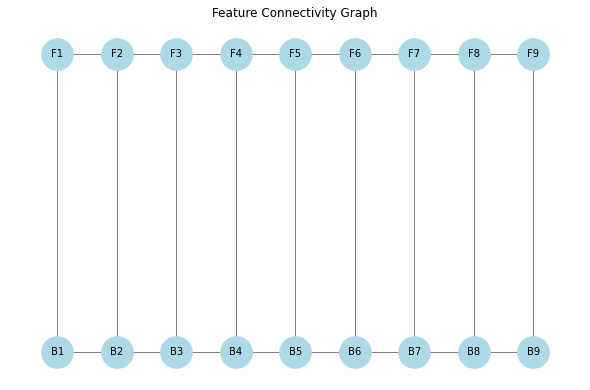

In [119]:
import networkx as nx
import matplotlib.pyplot as plt

# Define the edges as tuples
# edges = [('F1', 'F2'), ('F2', 'F3'), ('F4', 'F5'), ('F5', 'F6'), 
#          ('F7', 'F8'), ('F8', 'F9'), ('F5', 'F2'), ('F5', 'F8'),
#          ('F1', 'B1'), ('F2', 'B2'), ('F3', 'B3'), ('F4', 'B4'),
#          ('F5', 'B5'), ('F6', 'B6'), ('F7', 'B7'), ('F8', 'B8'),
#          ('F9', 'B9')]

# Create a graph
G = nx.Graph()
G.add_edges_from(edges)

# Define positions: F nodes on top, B nodes on bottom
pos = {}
for i, f in enumerate(['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9']):
    pos[f] = (i, 1)  # Row 1
for i, b in enumerate(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9']):
    pos[b] = (i, 0)  # Row 0

# Draw the graph
plt.figure(figsize=(8, 5))
nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=1000, font_size=10)
plt.title("Feature Connectivity Graph")
plt.show()


In [120]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv

class GATModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GATModel, self).__init__()
        # First GAT layer
        self.conv1 = GATConv(input_dim, hidden_dim, heads=1, dropout=0.2)
        # Second GAT layer
        self.conv2 = GATConv(hidden_dim, output_dim, heads=1, dropout=0.2)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        # First GAT layer
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        
        # Second GAT layer
        x = self.conv2(x, edge_index)
        
        return x


Epoch 10/400, Loss: 1.4016, MAE: 0.2812
Epoch 20/400, Loss: 0.7795, MAE: 0.2329
Epoch 30/400, Loss: 0.6722, MAE: 0.2185
Epoch 40/400, Loss: 0.5530, MAE: 0.2011
Epoch 50/400, Loss: 0.5418, MAE: 0.1923
Epoch 60/400, Loss: 0.4990, MAE: 0.1856
Epoch 70/400, Loss: 0.4666, MAE: 0.1796
Epoch 80/400, Loss: 0.4838, MAE: 0.1756
Epoch 90/400, Loss: 0.4671, MAE: 0.1735
Epoch 100/400, Loss: 0.4541, MAE: 0.1706
Epoch 110/400, Loss: 0.4461, MAE: 0.1676
Epoch 120/400, Loss: 0.4320, MAE: 0.1655
Epoch 130/400, Loss: 0.4137, MAE: 0.1634
Epoch 140/400, Loss: 0.4295, MAE: 0.1650
Epoch 150/400, Loss: 0.4235, MAE: 0.1630
Epoch 160/400, Loss: 0.4270, MAE: 0.1633
Epoch 170/400, Loss: 0.4112, MAE: 0.1613
Epoch 180/400, Loss: 0.4193, MAE: 0.1622
Epoch 190/400, Loss: 0.4119, MAE: 0.1602
Epoch 200/400, Loss: 0.4246, MAE: 0.1621
Epoch 210/400, Loss: 0.4206, MAE: 0.1615
Epoch 220/400, Loss: 0.4218, MAE: 0.1617
Epoch 230/400, Loss: 0.4070, MAE: 0.1598
Epoch 240/400, Loss: 0.4283, MAE: 0.1616
Epoch 250/400, Loss: 0.40

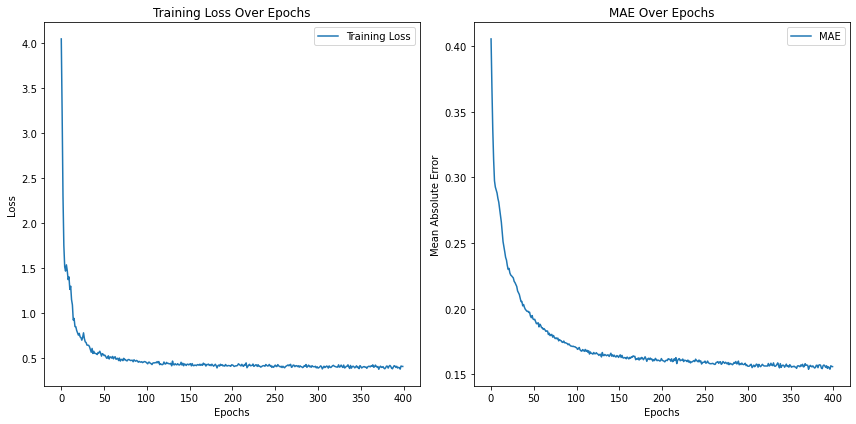

Evaluation - MSE: 0.1665, MAE: 0.1404


In [121]:
from torch_geometric.data import DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# Set device (CUDA or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move data to device
data = data.to(device)

# Define model
input_dim = data.x.shape[1]  # Number of features per node
hidden_dim = 64  # Hidden dimension size
output_dim = 2  # Predicting EtotF and EtotB

model = GATModel(input_dim, hidden_dim, output_dim).to(device)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = nn.MSELoss()

# Train the model
def train(model, data, optimizer, criterion, epochs=400):
    model.train()
    train_losses = []
    mae_scores = []  # List to store the MAE scores for each epoch
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data)  # Forward pass
        loss = criterion(out, data.y)  # Compute loss
        
        # Calculate MAE (Mean Absolute Error)
        mae = mean_absolute_error(data.y.cpu().numpy(), out.cpu().detach().numpy())
        
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        
        train_losses.append(loss.item())
        mae_scores.append(mae)
        
        if (epoch+1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, MAE: {mae:.4f}')
    
    return train_losses, mae_scores

# Train the model for 100 epochs
train_losses, mae_scores = train(model, data, optimizer, criterion, epochs=400)

# Plot training loss and MAE
plt.figure(figsize=(12, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(mae_scores, label='MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.title('MAE Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model
def evaluate(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data)
        mse = mean_squared_error(data.y.cpu().numpy(), out.cpu().numpy())  # MSE
        mae = mean_absolute_error(data.y.cpu().numpy(), out.cpu().numpy())  # MAE
    return mse, mae

# Get MSE and MAE on the test data
mse, mae = evaluate(model, data)
print(f'Evaluation - MSE: {mse:.4f}, MAE: {mae:.4f}')


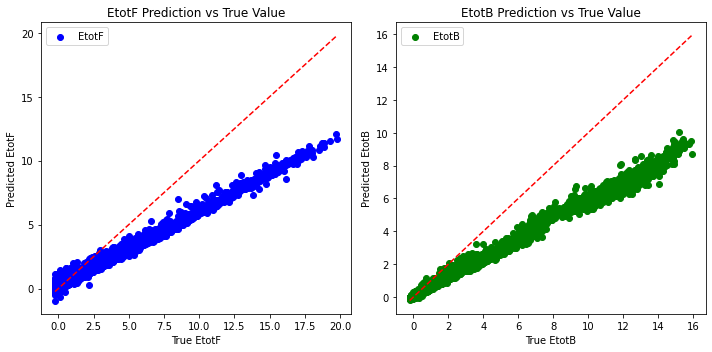

In [123]:
# Visualize predictions vs true values
def visualize_predictions(model, data):
    model.eval()
    with torch.no_grad():
        predictions = model(data)
        true_values = data.y.cpu().numpy()
        predicted_values = predictions.cpu().numpy()
        
        # Plot for EtotF and EtotB
        plt.figure(figsize=(10, 5))
        
        # Plot for EtotF (first output)
        plt.subplot(1, 2, 1)
        plt.scatter(true_values[:, 0], predicted_values[:, 0], label='EtotF', color='blue')
        plt.plot([true_values[:, 0].min(), true_values[:, 0].max()], 
                 [true_values[:, 0].min(), true_values[:, 0].max()], color='red', linestyle='--')
        plt.xlabel('True EtotF')
        plt.ylabel('Predicted EtotF')
        plt.title('EtotF Prediction vs True Value')
        plt.legend()
        
        # Plot for EtotB (second output)
        plt.subplot(1, 2, 2)
        plt.scatter(true_values[:, 1], predicted_values[:, 1], label='EtotB', color='green')
        plt.plot([true_values[:, 1].min(), true_values[:, 1].max()], 
                 [true_values[:, 1].min(), true_values[:, 1].max()], color='red', linestyle='--')
        plt.xlabel('True EtotB')
        plt.ylabel('Predicted EtotB')
        plt.title('EtotB Prediction vs True Value')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

# Visualize predictions for the current model
visualize_predictions(model, data)


In [124]:
# def plot_residuals(predictions, targets):
#     residuals_f = targets[:, 0].cpu() - predictions[:, 0].cpu()
#     residuals_b = targets[:, 1].cpu() - predictions[:, 1].cpu()
    
#     fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
#     # Plot residuals for EtotF
#     axes[0].hist(residuals_f, bins=30, color='green', edgecolor='black')
#     axes[0].set_title('Residuals for EtotF')
#     axes[0].set_xlabel('Residual (True - Predicted)')
#     axes[0].set_ylabel('Frequency')

#     # Plot residuals for EtotB
#     axes[1].hist(residuals_b, bins=30, color='orange', edgecolor='black')
#     axes[1].set_title('Residuals for EtotB')
#     axes[1].set_xlabel('Residual (True - Predicted)')
#     axes[1].set_ylabel('Frequency')

#     plt.tight_layout()
#     plt.show()

# # Plot the residuals

# #plot_residuals(predictions, targets)

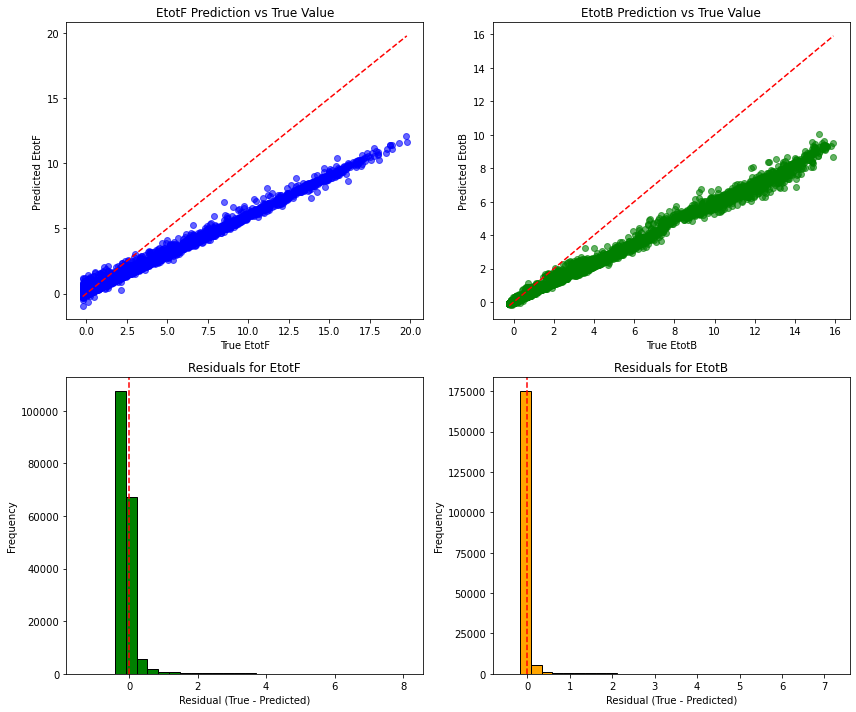

In [125]:
import torch
import matplotlib.pyplot as plt

def visualize_predictions_and_residuals(model, data):
    model.eval()
    with torch.no_grad():
        predictions = model(data)
        true_values = data.y.cpu()
        predicted_values = predictions.cpu()

        residuals_f = true_values[:, 0] - predicted_values[:, 0]
        residuals_b = true_values[:, 1] - predicted_values[:, 1]

        fig, axes = plt.subplots(2, 2, figsize=(12, 10))

        # Scatter plot for EtotF
        axes[0, 0].scatter(true_values[:, 0], predicted_values[:, 0], color='blue', alpha=0.6)
        axes[0, 0].plot([true_values[:, 0].min(), true_values[:, 0].max()], 
                        [true_values[:, 0].min(), true_values[:, 0].max()], color='red', linestyle='--')
        axes[0, 0].set_xlabel('True EtotF')
        axes[0, 0].set_ylabel('Predicted EtotF')
        axes[0, 0].set_title('EtotF Prediction vs True Value')

        # Scatter plot for EtotB
        axes[0, 1].scatter(true_values[:, 1], predicted_values[:, 1], color='green', alpha=0.6)
        axes[0, 1].plot([true_values[:, 1].min(), true_values[:, 1].max()], 
                        [true_values[:, 1].min(), true_values[:, 1].max()], color='red', linestyle='--')
        axes[0, 1].set_xlabel('True EtotB')
        axes[0, 1].set_ylabel('Predicted EtotB')
        axes[0, 1].set_title('EtotB Prediction vs True Value')

        # Histogram of residuals for EtotF
        axes[1, 0].hist(residuals_f.numpy(), bins=30, color='green', edgecolor='black')
        axes[1, 0].axvline(0, color='red', linestyle='--')  # Reference line at 0
        axes[1, 0].set_xlabel('Residual (True - Predicted)')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].set_title('Residuals for EtotF')

        # Histogram of residuals for EtotB
        axes[1, 1].hist(residuals_b.numpy(), bins=30, color='orange', edgecolor='black')
        axes[1, 1].axvline(0, color='red', linestyle='--')  # Reference line at 0
        axes[1, 1].set_xlabel('Residual (True - Predicted)')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].set_title('Residuals for EtotB')

        plt.tight_layout()
        plt.show()

# Visualize predictions and residuals
visualize_predictions_and_residuals(model, data)


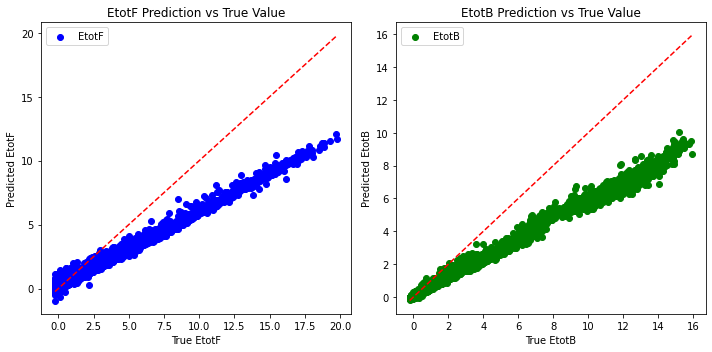

In [126]:
import torch
import matplotlib.pyplot as plt
import numpy as np


# Visualize predictions vs true values
def visualize_predictions_heatmap(model, data):
    model.eval()
    with torch.no_grad():
        predictions = model(data)
        true_values = data.y.cpu().numpy()
        predicted_values = predictions.cpu().numpy()
        
        # Plot for EtotF and EtotB
        plt.figure(figsize=(10, 5))
        
        # Plot for EtotF (first output)
        plt.subplot(1, 2, 1)
        plt.scatter(true_values[:, 0], predicted_values[:, 0], label='EtotF', color='blue')
        plt.plot([true_values[:, 0].min(), true_values[:, 0].max()], 
                 [true_values[:, 0].min(), true_values[:, 0].max()], color='red', linestyle='--')
        plt.xlabel('True EtotF')
        plt.ylabel('Predicted EtotF')
        plt.title('EtotF Prediction vs True Value')
        plt.legend()
        
        # Plot for EtotB (second output)
        plt.subplot(1, 2, 2)
        plt.scatter(true_values[:, 1], predicted_values[:, 1], label='EtotB', color='green')
        plt.plot([true_values[:, 1].min(), true_values[:, 1].max()], 
                 [true_values[:, 1].min(), true_values[:, 1].max()], color='red', linestyle='--')
        plt.xlabel('True EtotB')
        plt.ylabel('Predicted EtotB')
        plt.title('EtotB Prediction vs True Value')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

# Visualize predictions for the current model
visualize_predictions(model, data)




In [128]:
!pip install torchviz

DEPRECATION: gosam 2.1.1-4b98559 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of gosam or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
ERROR: Could not install packages due to an OSError: [Errno 30] Read-only file system: '/cvmfs/sft.cern.ch/lcg/releases/Python/3.11.9-2924c/x86_64-el9-gcc11-opt/lib/python3.11/site-packages/torchviz'



In [127]:
from torchviz import make_dot

def visualize_model_architecture(model, data):
    model.eval()
    output = model(data)
    make_dot(output, params=dict(model.named_parameters())).render("gat_model", format="png")

visualize_model_architecture(model, data)


ModuleNotFoundError: No module named 'torchviz'